# Free Diving into Food Facts

### Imports needed for the processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

Initiate the spark session and context.

In [2]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

Sanity check on the spark version and get the Spark UI link

In [3]:
spark

Load data with Spark (used for the upcoming exploration)

In [4]:
foodFacts_spark = spark.read.format("csv")\
                            .option("delimiter", '\t')\
                            .option("encoding", "UTF-8")\
                            .option("header", "true")\
                            .load("data/en.openfoodfacts.org.products.csv")

Load data with pandas

In [5]:
#foodFacts_df = pd.read_csv("data/en.openfoodfacts.org.products.csv", sep='\t', encoding='UTF-8')

In [6]:
foodFacts_spark.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

In [7]:
print('There are in total {} products in this list, including duplicates.' .format(foodFacts_spark.count()))

There are in total 1021880 products in this list, including duplicates.


Lets observe the difference between generic_name and product_name

In [8]:
product_counts_generic = foodFacts_spark.withColumn('generic_name', lower(col('generic_name')))\
                                        .groupBy("generic_name")\
                                        .agg(count("*").alias("ProductCount"))\
                                        .sort(desc("ProductCount"))
product_counts_generic.show()

+--------------------+------------+
|        generic_name|ProductCount|
+--------------------+------------+
|                null|      929460|
|pâtes alimentaire...|         171|
|               bière|         127|
|pâtes alimentaire...|         123|
|beignets fourrés ...|         122|
|beignets fourrés ...|         113|
|jambon cuit supér...|         107|
|       chocolat noir|         106|
|        jus d'orange|          99|
|  aliment pour bébés|          94|
|           vin rouge|          92|
|pâte feuilletée a...|          85|
|    chocolat au lait|          83|
|lait demi-écrémé ...|          79|
|        bière blonde|          73|
|natürliches miner...|          72|
|eau minérale natu...|          64|
|        jus de pomme|          63|
|  pâtes alimentaires|          63|
|plat préparé en c...|          61|
+--------------------+------------+
only showing top 20 rows



In [9]:
product_counts_standard = foodFacts_spark.withColumn('product_name', lower(col('product_name')))\
                                         .groupBy("product_name")\
                                         .agg(count("*").alias("ProductCount"))\
                                         .sort(desc("ProductCount"))
product_counts_standard.show()

+--------------------+------------+
|        product_name|ProductCount|
+--------------------+------------+
|                null|       50598|
|     produit inconnu|         810|
|               comté|         713|
|     filet de poulet|         693|
|huile d'olive vie...|         576|
|            emmental|         540|
|        jus de pomme|         513|
|aceite de oliva v...|         507|
|       huile d'olive|         498|
|                miel|         491|
|          mayonnaise|         449|
|    filets de poulet|         436|
|           ice cream|         424|
|extra virgin oliv...|         415|
|            chocolat|         406|
|           spaghetti|         386|
|        jus d'orange|         371|
|              poulet|         362|
|             ketchup|         335|
|      tomato ketchup|         310|
+--------------------+------------+
only showing top 20 rows



First observation is that the dataset contains a lot of undefined product. The name of the product is the most crucial information we need to actually determine what the row represents. Hence, we will drop these rows. (IDEA : regression to predict what product it was ?)

Second observation is that the product name will most likely be the interesting column as it regroups better similar products.

and third observation is that the dataset is constructed based on different languages...

In [10]:
foodFacts_spark = foodFacts_spark.where("product_name != 'null' AND product_name != 'Produit inconnu'")

In [11]:
product_counts_standard_cleaned = foodFacts_spark.withColumn('product_name', lower(col('product_name')))\
                                                 .groupBy("product_name")\
                                                 .agg(count("*").alias("ProductCount"))\
                                                 .sort(desc("ProductCount"))

product_counts_standard_cleaned.show()

+--------------------+------------+
|        product_name|ProductCount|
+--------------------+------------+
|               comté|         713|
|     filet de poulet|         693|
|huile d'olive vie...|         576|
|            emmental|         540|
|        jus de pomme|         513|
|aceite de oliva v...|         507|
|       huile d'olive|         498|
|                miel|         491|
|          mayonnaise|         449|
|    filets de poulet|         436|
|           ice cream|         424|
|extra virgin oliv...|         415|
|            chocolat|         406|
|           spaghetti|         386|
|        jus d'orange|         371|
|              poulet|         362|
|             ketchup|         335|
|      tomato ketchup|         310|
|        pain complet|         308|
|        potato chips|         300|
+--------------------+------------+
only showing top 20 rows



Let's observe if product having the same name overall have the same content. We'll focus on the Mayonnaise. The resulting dataset will be small enough to be put in a Pandas dataframe

# Mayonnaise analysis ;)

In [12]:
mayonnaise_comparison = foodFacts_spark.where("product_name = 'Mayonnaise'").toPandas()

In [13]:
mayonnaise_comparison.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0011110019141,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489062692,2017-03-09T12:31:32Z,1546199115,2018-12-30T19:45:15Z,Mayonnaise,None,None,...,None,24,24,None,None,None,None,None,None,None
1,0017548828119,http://world-en.openfoodfacts.org/product/0017...,usda-ndb-import,1489066739,2017-03-09T13:38:59Z,1557343065,2019-05-08T19:17:45Z,Mayonnaise,None,None,...,None,19,19,None,None,None,None,None,None,None
2,0021600103908,http://world-en.openfoodfacts.org/product/0021...,usda-ndb-import,1489094080,2017-03-09T21:14:40Z,1557343032,2019-05-08T19:17:12Z,Mayonnaise,None,None,...,None,24,24,None,None,None,None,None,None,None
3,0023005002107,http://world-en.openfoodfacts.org/product/0023...,kiliweb,1546122366,2018-12-29T22:26:06Z,1547475647,2019-01-14T14:20:47Z,Mayonnaise,None,None,...,None,None,None,None,None,None,None,None,None,None
4,0026700157387,http://world-en.openfoodfacts.org/product/0026...,usda-ndb-import,1489062118,2017-03-09T12:21:58Z,1557343007,2019-05-08T19:16:47Z,Mayonnaise,None,None,...,None,24,24,None,None,None,None,None,None,None


Let's compare the UK and FR nutrition scores.

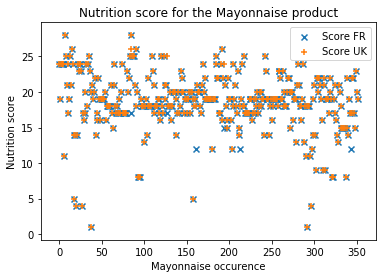

In [14]:
columns = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']
clean_mayonnaise = mayonnaise_comparison.dropna(subset=columns).copy()
clean_mayonnaise[columns] = clean_mayonnaise[columns].applymap(int)

plt.scatter(range(len(clean_mayonnaise['nutrition-score-fr_100g'])), clean_mayonnaise['nutrition-score-fr_100g'], marker='x', label='Score FR')
plt.scatter(range(len(clean_mayonnaise['nutrition-score-uk_100g'])), clean_mayonnaise['nutrition-score-uk_100g'], marker='+', label='Score UK')
plt.legend()
plt.ylabel('Nutrition score')
plt.xlabel('Mayonnaise occurence')
plt.title('Nutrition score for the Mayonnaise product')
plt.show()

Let's try to highlight the difference

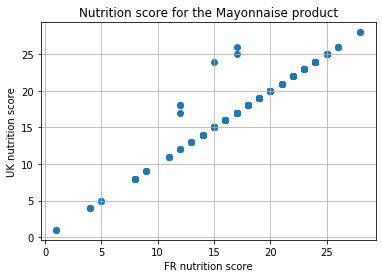

In [15]:
plt.scatter(clean_mayonnaise['nutrition-score-fr_100g'], clean_mayonnaise['nutrition-score-uk_100g'])
plt.ylabel('UK nutrition score')
plt.xlabel('FR nutrition score')
plt.title('Nutrition score for the Mayonnaise product')
plt.grid(True)
plt.show()

In [16]:
print ("We conclude that the UK and FR nutrition scores should be equal and that there are some errors in the dataset,"
       "which is not very surprising for an opensource dataset. Considering the nutrition score for "
       "the mayonnaise product, {}% of the data is ambiguous." \
       .format(100 - np.sum(clean_mayonnaise['nutrition-score-fr_100g'] == clean_mayonnaise['nutrition-score-uk_100g'])*100 / len(clean_mayonnaise)))

We conclude that the UK and FR nutrition scores should be equal and that there are some errors in the dataset,which is not very surprising for an opensource dataset. Considering the nutrition score for the mayonnaise product, 1.7045454545454533% of the data is ambiguous.


Let's do a similar analysis but for the content in saturated fat as the Mayonnaise product should containt a lot of fat.

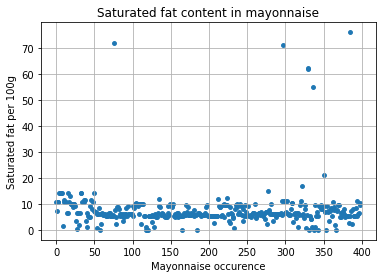

In [17]:
clean_mayonnaise = mayonnaise_comparison.dropna(subset=['saturated-fat_100g']).copy()
clean_mayonnaise['saturated-fat_100g'] = clean_mayonnaise['saturated-fat_100g'].map(float)

plt.scatter(range(len(clean_mayonnaise)), clean_mayonnaise['saturated-fat_100g'], marker='o',s=15)
plt.title('Saturated fat content in mayonnaise')
plt.xlabel('Mayonnaise occurence')
plt.ylabel('Saturated fat per 100g')
plt.grid(True)
plt.show()

Here we observe some divergence in the dataset with a few outliers. This may come from the fact that this mayonnaise product contains different types of mayonnaise, such as light mayonnaise etc.. <br>
Let's check

In [18]:
product_counts_standard_cleaned.filter(col('product_name').contains('mayonnaise')).show()

+--------------------+------------+
|        product_name|ProductCount|
+--------------------+------------+
|          mayonnaise|         449|
|     real mayonnaise|         116|
|mayonnaise à la m...|          69|
|    light mayonnaise|          37|
| mayonnaise de dijon|          25|
|  organic mayonnaise|          22|
|      mayonnaise bio|          17|
|   mayonnaise légère|          17|
|mayonnaise au citron|          15|
|   mayonnaise nature|          13|
|mayonnaise dressi...|          12|
|  mayonnaise allégée|          11|
|mayonnaise aux oe...|          10|
|mayonnaise aux oeufs|          10|
|    mayonnaise light|          10|
|macédoine de légu...|           9|
|   mayonnaise citron|           9|
|thon sauce mayonn...|           9|
|delikatess mayonn...|           9|
|mayonnaise à la m...|           8|
+--------------------+------------+
only showing top 20 rows



We remark that the different types of mayonnaise have different names, hence one can assume that the "mayonnaise" product only contains the standard mayonnaise.

Hence, this product has some divergence in at least the field representing the saturated fat. This may come from the fact that this is an opensource dataset, hence some people may have simply rounded the number that they read/analysed on the product list of content.